In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
files = glob.glob("../data/*.CSV")

In [3]:
def process_df(df):
    '''
    Converts time stamp column from String datetime to seconds starting from 0 
    and rounds values of selected columns (all but PC Source X Freq and PC Source X Q) 
    to 3 decimals
    
    Parameters
    ----------
    df: pandas df of experiment CSV
    
    
    Returns
    ---------
    date: string of experiment date (mm/dd/yy)
    df: pandas df with converted time column and 3 decimal values for all columns
    '''
    
    # Convert to datetime
    df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])
    
    # Save date
    date = df['Time Stamp'].iloc[0].date().strftime('%m/%d/%Y')

    # Convert datetime to seconds starting from zero
    df['Time Stamp'] = (df['Time Stamp'] - df['Time Stamp'].iloc[0]).dt.total_seconds()
    
    # Round selected columns to three decimals
    rounded_columns = []

    for i in df.columns.values:
        if 'PC Source' not in i:
            rounded_columns.append(i)

    df[rounded_columns] = df[rounded_columns].round(3)

    
    return date, df

# Formula for identifying a steady experiment

- let $\sigma_t$ be the standard deviation which indicates the threshold for stability. We can use 1 as a default value if no specific value is given (default value based on exploratory analysis);
- let $t \in (0,1)$ be the percentage threshold that marks the cutoff point in time for a steady experiment, e.g. if $t = 0.5$, then at least the entire last half of the experiment must be steady for an experiment to be considered steady;
- let $\boldsymbol{P}$ be a set containing the parameters that define the steady experiment. For an experiment to be considered steady, **all** parameters $p \in \boldsymbol{P}$ must fulfill $\sigma_p \leq \sigma_t$;
- let $n$ be the number of time series measurements.

To identify whether an experiment reaches steady state, we iterate through the time series measurements of an experiment from index $j = 1, ..., t \times n$. In each iteration, if all time series measurements $t_j,...,t_n$  for all parameters $p \in \boldsymbol{P}$ has a standard deviation $\sigma \leq \sigma_t$, then the experiment is classified as steady from $t_j$ to $t_n$. If the experiment has not been classified as steady until iteration $t \times n$, then the experiment is considered unsteady.

## Add-on

We also want to check if the experiment settles after $t$ up to some time cutoff (settling with e.g. 0.1s left is not considered steady). If it does, we want to rerun the experiment with the same settings.

- let $t_d \in (0, 1 - t)$ be the time window to check for steadiness after $t$.

From $k = t \times n , ..., t \times n + t_d$, check if all time series measurements $t_k,...,t_n$  for all parameters $p \in \boldsymbol{P}$ has a standard deviation $\sigma \leq \sigma_t$, then the experiment is classified as steady from $t_k$ to $t_n$, and we send a signal to rerun the experiment with the same settings.

In [4]:
plt.rcParams['figure.figsize'] = [12, 6]
fig = plt.figure()
fig.tight_layout()

<Figure size 1200x600 with 0 Axes>

In [11]:
def steady(params, t=0.5, t_d = 0.3, sigma_t=1):

    for i in range(len(files)):

        # Read csv
        df = pd.read_csv(files[i], skiprows=[0,1])

        # Retrieve date and processed df
        date, df = process_df(df)

        rows = len(df.axes[0])
        cols = len(df.axes[1])

        # Find steady state threshold as index
        n_t = int(t*rows)
        
        # Find steady state drag threshold as index
        n_td = int(t_d*rows)
        
        # Plot voltages
        xs = df.index
        ys1 = df[p1]
        ys2 = df[p2]
        ys3 = df[p3]

        plt.subplot(3, 4, i+1)
        plt.plot(xs,ys1)
        plt.plot(xs,ys2)
        plt.plot(xs,ys3)
        
        for j in range(0, n_t + n_td):

            if all(df[p].tail(rows-j).std() <= sigma_t for p in params):
                plt.axvline(x = j, color='black', linestyle='dashed')
                if (j <= n_t):
                    print(f'Experiment {i+1}: Length {rows}, n_t = {n_t}, classified as steady at iteration {j}, time: { df["Time Stamp"].iloc[j] }s')
                    break
                else:
                    print(f'RERUN experiment {i+1}: Length {rows}, n_td = {n_td}, at iteration {j}, time: { df["Time Stamp"].iloc[j] }s')
                    break

plt.show()

Experiment 1: Length 185, n_t = 92, classified as steady at iteration 0, time: 0.0s
Experiment 2: Length 189, n_t = 94, classified as steady at iteration 43, time: 4.65s
Experiment 4: Length 224, n_t = 112, classified as steady at iteration 6, time: 0.653s
Experiment 5: Length 199, n_t = 99, classified as steady at iteration 10, time: 1.06s
Experiment 6: Length 206, n_t = 103, classified as steady at iteration 8, time: 0.874s
Experiment 7: Length 189, n_t = 94, classified as steady at iteration 12, time: 1.276s
Experiment 9: Length 205, n_t = 102, classified as steady at iteration 31, time: 3.378s
Experiment 10: Length 195, n_t = 97, classified as steady at iteration 0, time: 0.0s
Experiment 12: Length 207, n_t = 103, classified as steady at iteration 24, time: 2.593s


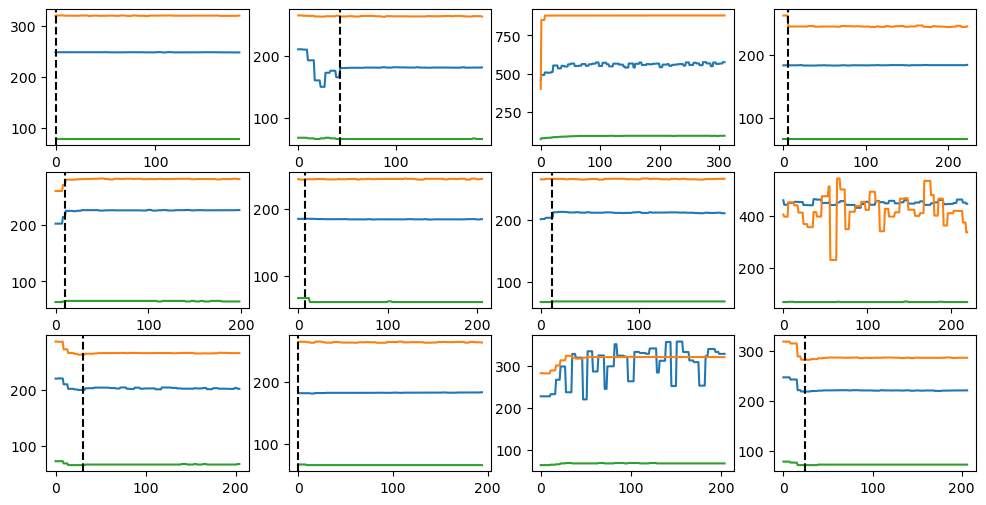

In [12]:
p1 = 'Power Supply 1 Voltage'
p2 = 'Power Supply 3 Voltage'
p3 = 'Power Supply 5 DC Bias'

steady_params = [p1,p2,p3]

steady(steady_params)
        